In [ ]:
# Install required packages
!pip install transformers torchaudio sentencepiece datasets torchcodec jiwer matplotlib

print("Packages installed ...✅")

  Using cached torchcodec-0.9.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (11 kB)
Using cached torchcodec-0.9.1-cp312-cp312-manylinux_2_28_x86_64.whl (2.1 MB)


KeyboardInterrupt: 

In [ ]:
# Load the dataset
from datasets import load_dataset
try:
    ds = load_dataset("facebook/multilingual_librispeech", "spanish", split="test")
    print(f"\n<<< DATASET LOADED WITH {len(ds)} SAMPLES >>>\n")
except Exception as e:
    print(f"\n<<< FAILED TO LOAD DATASET: {e} >>>\n")

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]


<<< DATASET LOADED WITH 2385 SAMPLES >>>



In [ ]:
# Prepare the dataset
processed_samples = []
target_count = 10
max_seconds = 15

print("<<< PROCESSING AUDIO SAMPLES >>>")

# Iterate through the dataset
for i, sample in enumerate(ds):
    if len(processed_samples) >= target_count:
        break

    # Extract audio data
    audio_data = sample['audio']
    original_array = audio_data['array']
    sampling_rate = audio_data['sampling_rate']

    # 3. Calculate cutoff point (Duration * Frequency)
    # limit_index = 15 * 16000 (usually)
    limit_index = int(max_seconds * sampling_rate)

    # 4. Truncate the numpy array
    # If the file is shorter than 15s, this slice keeps the original length
    truncated_array = original_array[:limit_index]

    # Create a new dictionary for the processed sample
    processed_sample = {
        'audio': {'array': truncated_array, 'sampling_rate': sampling_rate},
        'text': sample['transcript'] # Corrected from sample['text'] to sample['transcript']
    }

    processed_samples.append(processed_sample)

    # Print details to verify
    duration = len(truncated_array) / sampling_rate
    print(f"Sample {i+1}: Text: '{sample['transcript'][:30]}...' | New Duration: {duration:.2f}s") # Corrected print statement

<<< PROCESSING AUDIO SAMPLES >>>
Sample 1: Text: 'y las almas buscando algún ali...' | New Duration: 15.00s
Sample 2: Text: 'cuando calla el dolor se oye a...' | New Duration: 15.00s
Sample 3: Text: 'echar fuera la vida y acallar ...' | New Duration: 15.00s
Sample 4: Text: 'el vivir con el hombre pobre b...' | New Duration: 15.00s
Sample 5: Text: 'no sabe lo que busca y tú para...' | New Duration: 15.00s
Sample 6: Text: 'como todas las penas aunque ta...' | New Duration: 14.96s
Sample 7: Text: 'pero allí no tendremos en torn...' | New Duration: 14.71s
Sample 8: Text: 'tú has muerto en mansedumbre t...' | New Duration: 10.49s
Sample 9: Text: 'el que gime junto a la tumba d...' | New Duration: 13.51s
Sample 10: Text: 'allá en el otro mundo tu alma ...' | New Duration: 15.00s


In [ ]:
# Play audio samples
import IPython.display as ipd

print("<<< PLAYING PROCESSED AUDIO SAMPLES >>>")
for i, sample in enumerate(processed_samples):
    print(f"\n--- Sample {i+1} ---")
    print(f"Transcript: {sample['text']}")
    ipd.display(ipd.Audio(data=sample['audio']['array'], rate=sample['audio']['sampling_rate']))

In [ ]:
from transformers import AutoProcessor, SeamlessM4Tv2Model
import torchaudio
import torch
import numpy as np

# Load model and processor
model_id = "facebook/seamless-m4t-v2-large"
processor = AutoProcessor.from_pretrained(model_id)
model = SeamlessM4Tv2Model.from_pretrained(model_id)
print(f"\n<<< {model_id} LOADED SUCCESSFULLY ✅>>>")

Instantiating a decoder SeamlessM4Tv2Attention without passing `layer_idx` is not recommended and will lead to errors during the forward call, if caching is used. Please make sure to provide a `layer_idx` when creating this class.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


<<< facebook/seamless-m4t-v2-large LOADED SUCCESSFULLY ✅>>>


In [ ]:
print("<<< PERFORMING SPEECH-TO-TEXT WITH SEAMLESS-M4T-V2-LARGE >>>")

model_sampling_rate = processor.feature_extractor.sampling_rate
print(f"Model expects audio at {model_sampling_rate} Hz.")

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Model moved to {device} for inference.")


for i, sample_data in enumerate(processed_samples):
    audio_array_np = sample_data['audio']['array'] # This is a numpy array
    current_sampling_rate = sample_data['audio']['sampling_rate']
    original_text = sample_data['text']

    # Convert numpy array to torch tensor
    audio_tensor = torch.from_numpy(audio_array_np).float() # Keep on CPU for initial processing

    # Resample if necessary
    if current_sampling_rate != model_sampling_rate:
        print(f"Resampling audio for sample {i+1} from {current_sampling_rate} Hz to {model_sampling_rate} Hz...")
        resampler = torchaudio.transforms.Resample(orig_freq=current_sampling_rate, new_freq=model_sampling_rate)
        audio_input_for_processor = resampler(audio_tensor)
    else:
        audio_input_for_processor = audio_tensor

    # Prepare audio input for the model
    # Pass the torch tensor (on CPU) to the processor.
    inputs = processor(audio=audio_input_for_processor, sampling_rate=model_sampling_rate, src_lang="spa", return_tensors="pt")

    # Move inputs to device (GPU if available) for model inference
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate speech-to-text output
    generated_tokens = model.generate(
        input_features=inputs['input_features'],
        tgt_lang="spa",
        generate_speech=False
    )

    # Decode the generated tokens to text
    # Access generated_tokens[0][0] to flatten the list of lists if model.generate returns an extra dimension
    translated_text = processor.decode(generated_tokens[0][0].tolist(), skip_special_tokens=True)

    # Store original and generated texts in the processed_samples list
    sample_data['original_text'] = original_text # Added for clarity
    sample_data['generated_text'] = translated_text

    print(f"\n--- Sample {i+1} ---")
    print(f"Original Text (transcript): '{original_text}'")
    print(f"Generated Text (SeamlessM4T): '{translated_text}'")

print("\n<<< SPEECH-TO-TEXT PROCESSING COMPLETE >>>")

<<< PERFORMING SPEECH-TO-TEXT WITH SEAMLESS-M4T-V2-LARGE >>>
Model expects audio at 16000 Hz.
Model moved to cuda for inference.
Resampling audio for sample 1 from 48000 Hz to 16000 Hz...

--- Sample 1 ---
Original Text (transcript): 'y las almas buscando algún alivio se revuelven ansiosas y hacen el mundo que así resulta ser del dolor obra el dolor o la nada quien tenga corazón venga y escoja'
Generated Text (SeamlessM4T): 'y las almas buscando algún alivio se revuelven ansiosas y hacen el mundo que así resulta ser del dolor obra el dolor o la nada quien tenga corazón venga y'
Resampling audio for sample 2 from 48000 Hz to 16000 Hz...

--- Sample 2 ---
Original Text (transcript): 'cuando calla el dolor se oye a la muerte las alas tenebrosas batir en los profundos cual si fuesen las olas del mar de la ilusión en que los seres sin rumbo bogan donde se mecen frágiles barquillas las fugitivas formas'
Generated Text (SeamlessM4T): 'cuando calla el dolor se oye a la muerte las alas tenebros

<<< CALCULATING WORD ERROR RATE (WER) >>>
Sample 1 WER: 0.0323
Sample 2 WER: 0.1220
Sample 3 WER: 0.1463
Sample 4 WER: 0.1000
Sample 5 WER: 0.2174
Sample 6 WER: 0.0000
Sample 7 WER: 0.0000
Sample 8 WER: 0.0500
Sample 9 WER: 0.0000
Sample 10 WER: 0.1176

Average WER: 0.0786
<<< WER CALCULATION COMPLETE >>>


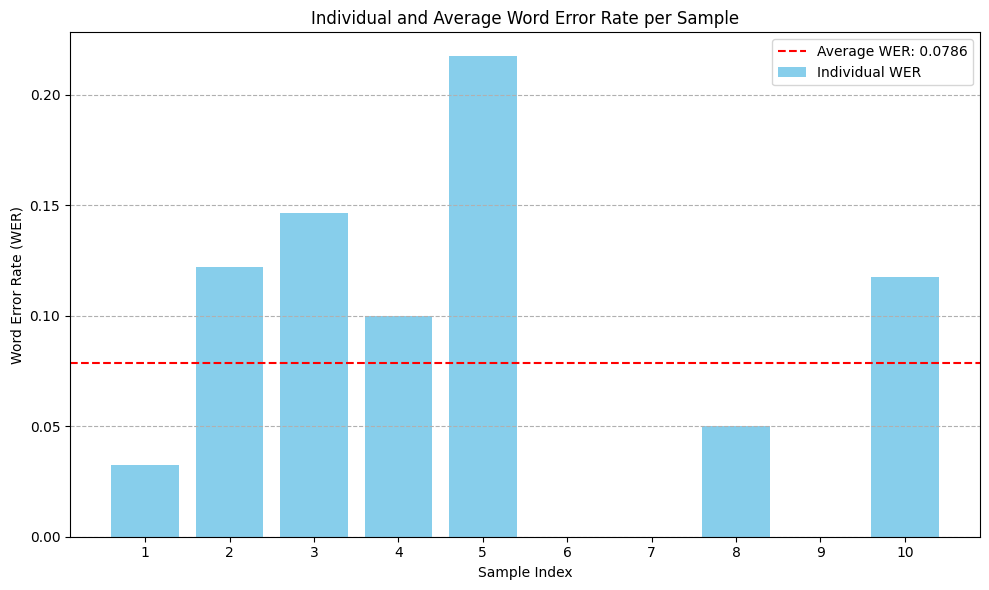

<<< WER VISUALIZATION COMPLETE >>>


In [ ]:
import jiwer
import matplotlib.pyplot as plt

# List to store individual WERs
wers = []

print("<<< CALCULATING WORD ERROR RATE (WER) >>>")

# Calculate WER for each sample
for i, sample_data in enumerate(processed_samples):
    original_text = sample_data['original_text']
    generated_text = sample_data['generated_text']

    # Calculate WER
    error = jiwer.wer(original_text, generated_text)
    wers.append(error)
    sample_data['wer'] = error # Store WER back into the sample_data

    print(f"Sample {i+1} WER: {error:.4f}")

# Calculate average WER
average_wer = sum(wers) / len(wers)
print(f"\nAverage WER: {average_wer:.4f}")

print("<<< WER CALCULATION COMPLETE >>>")

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(wers) + 1), wers, color='skyblue', label='Individual WER')
plt.axhline(y=average_wer, color='r', linestyle='--', label=f'Average WER: {average_wer:.4f}')
plt.xlabel('Sample Index')
plt.ylabel('Word Error Rate (WER)')
plt.title('Individual and Average Word Error Rate per Sample')
plt.xticks(range(1, len(wers) + 1))
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("<<< WER VISUALIZATION COMPLETE >>>")
